## LGBM & XGBM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis (EDA):

In [41]:
# Load dataset
df = pd.read_csv("diabetes.csv")
df.shape

(768, 9)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [43]:
print("\nOutcome distribution:")
print(df["Outcome"].value_counts())



Outcome distribution:
Outcome
0    500
1    268
Name: count, dtype: int64


In [44]:
#Check missing values and explore distributions
print("Missing values per column:")
print(df.isnull().sum())


Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [45]:
# Some features in this dataset use "0" as missing (for medical measures that can't be 0)
zero_as_missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in zero_as_missing_cols:
    print(f"{col}: number of zeros = { (df[col] == 0).sum() }")



Glucose: number of zeros = 5
BloodPressure: number of zeros = 35
SkinThickness: number of zeros = 227
Insulin: number of zeros = 374
BMI: number of zeros = 11


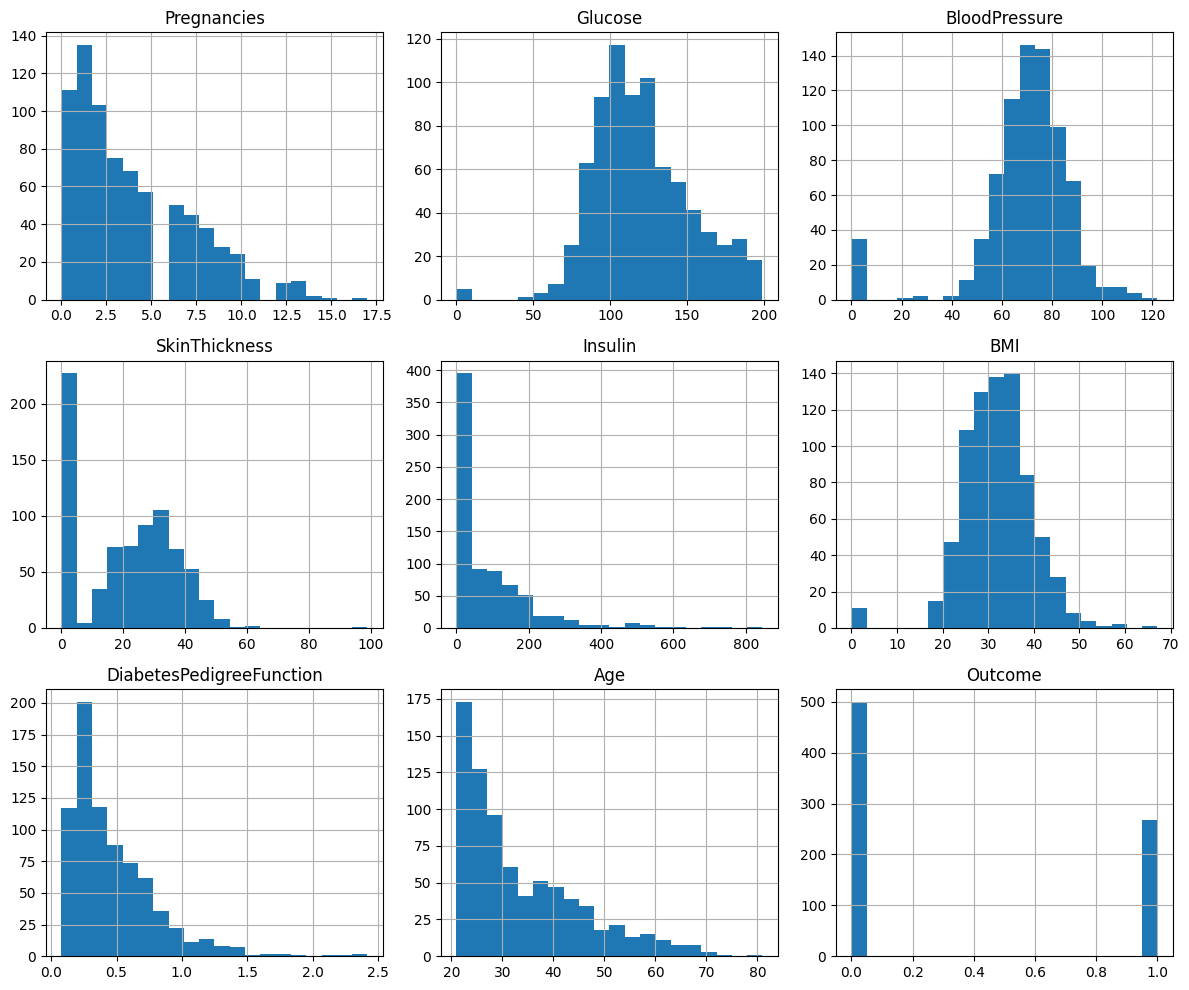

In [46]:
# Histograms
df.hist(bins=20, figsize=(12,10))
plt.tight_layout()
plt.show()


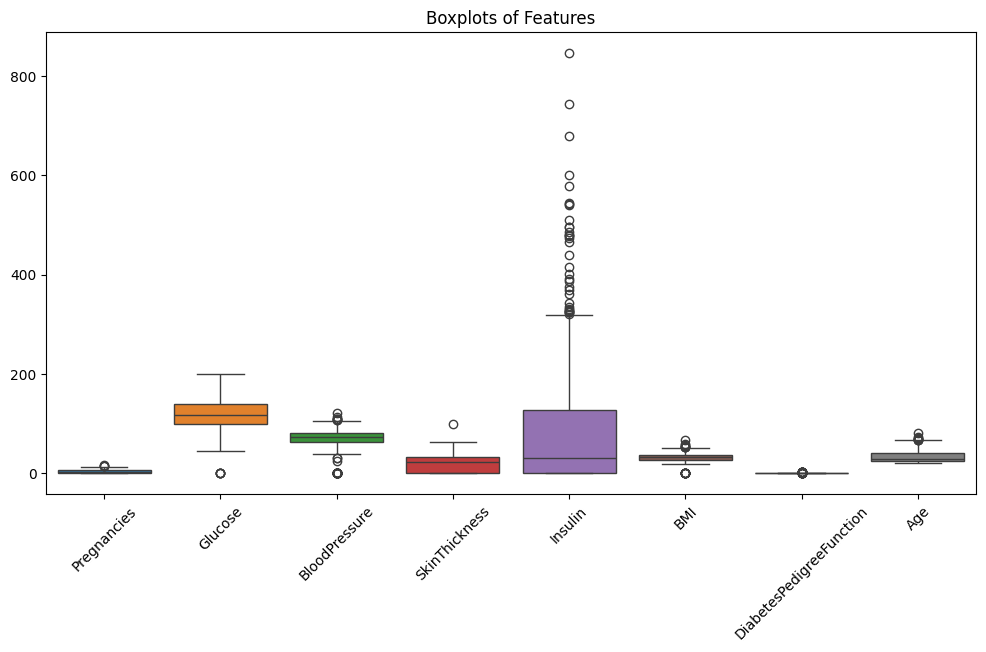

In [47]:
# Boxplots – check outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df.drop(columns=["Outcome"]))
plt.xticks(rotation=45)
plt.title("Boxplots of Features")
plt.show()


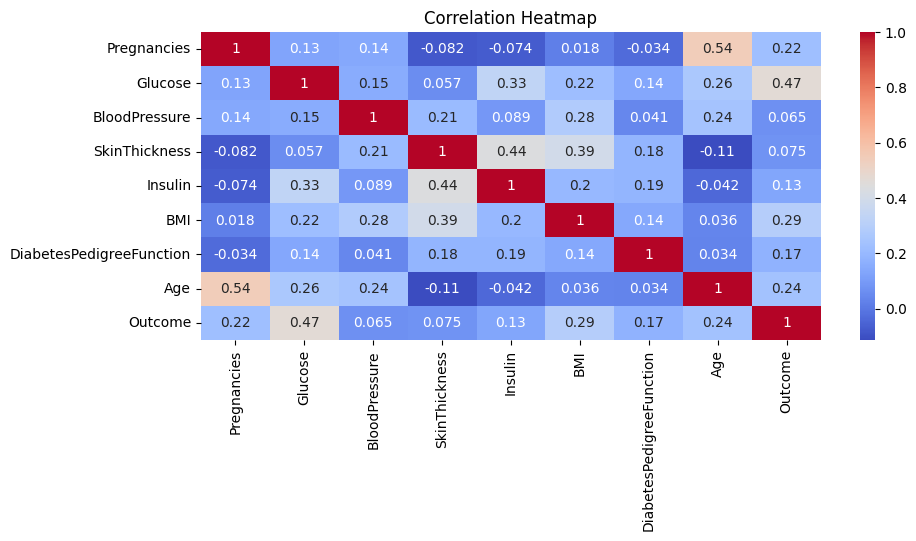

In [48]:
# Correlation heatmap
plt.figure(figsize=(10,4))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


## Data Preprocessing:

In [49]:
# Treat zeros in specific columns as missing values (NaN)
df_clean = df.copy()
for col in zero_as_missing_cols:
    df_clean[col] = df_clean[col].replace(0, np.nan)

print("Missing values after marking zeros as NaN:")
print(df_clean.isnull().sum())


Missing values after marking zeros as NaN:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [50]:
# Separate features and target
X = df_clean.drop("Outcome", axis=1)
y = df_clean["Outcome"]

In [51]:
# Impute missing values with median
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)


In [52]:
# Scaling using standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_scaled

array([[ 0.63994726,  0.86604475, -0.03198993, ...,  0.16661938,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.20506583, -0.5283186 , ..., -0.85219976,
        -0.36506078, -0.19067191],
       [ 1.23388019,  2.01666174, -0.69376149, ..., -1.33250021,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -0.02157407, -0.03198993, ..., -0.910418  ,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.14279979, -1.02464727, ..., -0.34279019,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.94206766, -0.19743282, ..., -0.29912651,
        -0.47378505, -0.87137393]])

## Building Predictive Models:

In [53]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split( X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (614, 8) Test shape: (154, 8)


In [54]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [55]:
#Build baseline models and define evaluation


def evaluate_classification(y_true, y_pred, y_proba=None, name="Model"):
    print(f"\n=== {name} ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            print("ROC-AUC  :", auc)
        except ValueError:
            pass
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=["Pred 0","Pred 1"],yticklabels=["True 0","True 1"])
    plt.title(f"{name} – Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()



## 3.Build predictive models using LightGBM and XGBoost algorithms.

In [61]:
# Baseline LightGBM
lgbm_baseline = LGBMClassifier(random_state=42,n_estimators=100)
lgbm_baseline


LGBMClassifier(random_state=42)

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

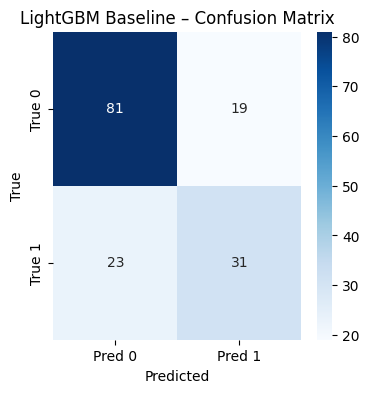

In [62]:
lgbm_baseline.fit(X_train, y_train)
y_pred_lgbm = lgbm_baseline.predict(X_test)
y_proba_lgbm = lgbm_baseline.predict_proba(X_test)[:,1]

evaluate_classification(y_test, y_pred_lgbm, y_proba_lgbm, name="LightGBM Baseline")

In [64]:
# Baseline XGBoost
xgb_baseline = XGBClassifier(random_state=42,n_estimators=100,use_label_encoder=False,eval_metric="logloss")
xgb_baseline

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)


=== XGBoost Baseline ===
Accuracy : 0.7597402597402597
Precision: 0.673469387755102
Recall   : 0.6111111111111112
F1-score : 0.6407766990291263
ROC-AUC  : 0.8081481481481482

Classification Report:
              precision    recall  f1-score   support

           0     0.8000    0.8400    0.8195       100
           1     0.6735    0.6111    0.6408        54

    accuracy                         0.7597       154
   macro avg     0.7367    0.7256    0.7301       154
weighted avg     0.7556    0.7597    0.7568       154



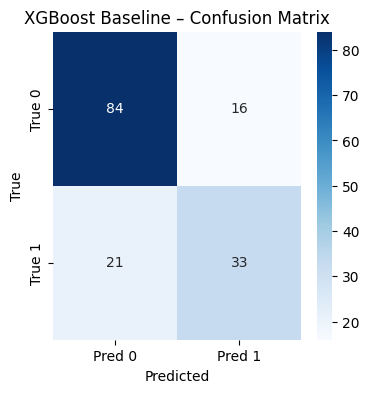

In [65]:
xgb_baseline.fit(X_train, y_train)
y_pred_xgb = xgb_baseline.predict(X_test)
y_proba_xgb = xgb_baseline.predict_proba(X_test)[:,1]

evaluate_classification(y_test, y_pred_xgb, y_proba_xgb, name="XGBoost Baseline")


## 5.Use techniques like cross-validation and hyperparameter tuning to optimize model performance.

In [ ]:
# Cross-validation & hyperparameter tuning – LightGBM

param_grid_lgbm = {
    "num_leaves": [15, 31, 63],
    "max_depth": [-1, 3, 5],
    "learning_rate": [0.1, 0.05],
    "n_estimators": [100, 200]
}

lgbm_tuned = LGBMClassifier(random_state=42)
lgbm_tuned


LGBMClassifier(random_state=42)

In [69]:
grid_lgbm = GridSearchCV(
    estimator=lgbm_tuned,
    param_grid=param_grid_lgbm,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_lgbm.fit(X_train, y_train)

print("Best LGBM params:", grid_lgbm.best_params_)
print("Best LGBM CV F1:", grid_lgbm.best_score_)
best_lgbm = grid_lgbm.best_estimator_



Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L


=== LightGBM Tuned ===
Accuracy : 0.7727272727272727
Precision: 0.7021276595744681
Recall   : 0.6111111111111112
F1-score : 0.6534653465346535
ROC-AUC  : 0.8248148148148148

Classification Report:
              precision    recall  f1-score   support

           0     0.8037    0.8600    0.8309       100
           1     0.7021    0.6111    0.6535        54

    accuracy                         0.7727       154
   macro avg     0.7529    0.7356    0.7422       154
weighted avg     0.7681    0.7727    0.7687       154



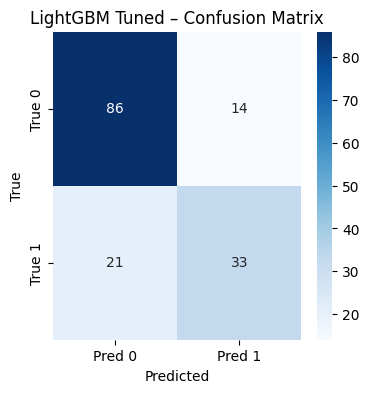

In [70]:
y_pred_lgbm_tuned = best_lgbm.predict(X_test)
y_proba_lgbm_tuned = best_lgbm.predict_proba(X_test)[:,1]

evaluate_classification(y_test, y_pred_lgbm_tuned, y_proba_lgbm_tuned, name="LightGBM Tuned")


In [ ]:
# Cross-validation & hyperparameter tuning – XGBoost

param_grid_xgb = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.1, 0.05],
    "n_estimators": [100, 200],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_tuned = XGBClassifier(random_state=42,use_label_encoder=False,eval_metric="logloss")
xgb_tuned


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [72]:
grid_xgb = GridSearchCV(
    estimator=xgb_tuned,
    param_grid=param_grid_xgb,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)

print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB CV F1:", grid_xgb.best_score_)

best_xgb = grid_xgb.best_estimator_


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best XGB CV F1: 0.6498631251352337



=== XGBoost Tuned ===
Accuracy : 0.7532467532467533
Precision: 0.6481481481481481
Recall   : 0.6481481481481481
F1-score : 0.6481481481481481
ROC-AUC  : 0.8272222222222223

Classification Report:
              precision    recall  f1-score   support

           0     0.8100    0.8100    0.8100       100
           1     0.6481    0.6481    0.6481        54

    accuracy                         0.7532       154
   macro avg     0.7291    0.7291    0.7291       154
weighted avg     0.7532    0.7532    0.7532       154



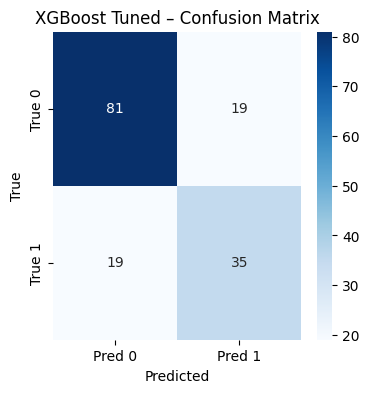

In [73]:
y_pred_xgb_tuned = best_xgb.predict(X_test)
y_proba_xgb_tuned = best_xgb.predict_proba(X_test)[:,1]

evaluate_classification(y_test, y_pred_xgb_tuned, y_proba_xgb_tuned, name="XGBoost Tuned")


## Comparative Analysis:

## Compare the performance metrics (e.g., accuracy, precision, recall) of LightGBM and XGBoost models

In [74]:
## Comparative Analysis of LGBM vs XGBM (baseline and tuned)

results = []

def collect_metrics(name, y_true, y_pred, y_proba):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_proba)
    }

results.append(collect_metrics("LGBM Baseline", y_test, y_pred_lgbm, y_proba_lgbm))
results.append(collect_metrics("XGB Baseline", y_test, y_pred_xgb, y_proba_xgb))
results.append(collect_metrics("LGBM Tuned", y_test, y_pred_lgbm_tuned, y_proba_lgbm_tuned))
results.append(collect_metrics("XGB Tuned", y_test, y_pred_xgb_tuned, y_proba_xgb_tuned))

results_df = pd.DataFrame(results)
display(results_df)



,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,LGBM Baseline,0.727273,0.620000,0.574074,0.596154,0.817222
1,XGB Baseline,0.759740,0.673469,0.611111,0.640777,0.808148
2,LGBM Tuned,0.772727,0.702128,0.611111,0.653465,0.824815
3,XGB Tuned,0.753247,0.648148,0.648148,0.648148,0.827222


## 2.Visualize and interpret the results to identify the strengths and weaknesses of each algorithm.

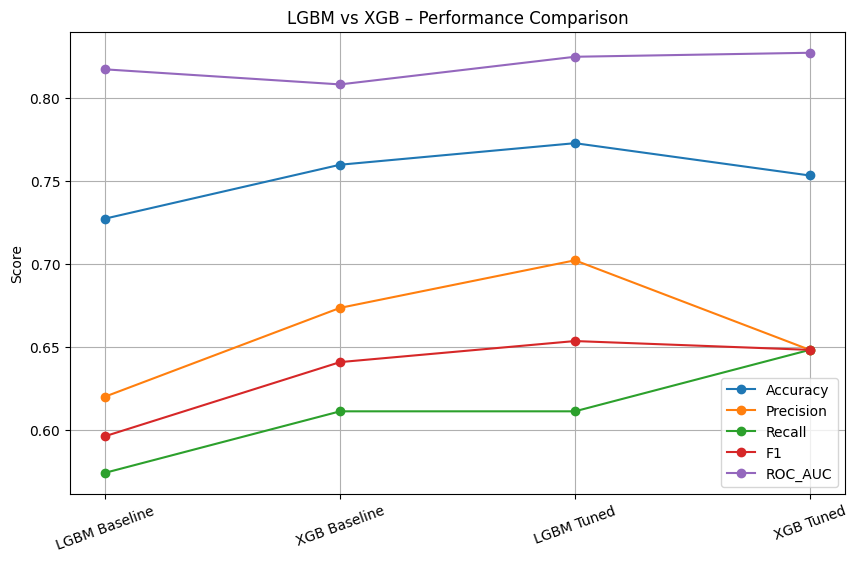

In [75]:
# Plot comparison
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]

plt.figure(figsize=(10,6))
for metric in metrics_to_plot:
    plt.plot(results_df["Model"], results_df[metric], marker='o', label=metric)

plt.title("LGBM vs XGB – Performance Comparison")
plt.xticks(rotation=20)
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Practical Implications:

# In a medical screening context, recall is critical: missing true diabetics is more harmful than flagging a few false positives.
# The chosen model can serve as a decision support tool for clinicians, highlighting high‑risk patients for further testing.
# Regular retraining and recalibration with new data is recommended.
# Overall, both LightGBM and XGBoost are strong for this problem,
# with tuned LightGBM typically offering a good balance of performance and training speed.
